In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image
from torchvision import transforms
import numpy as np

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class test(nn.Module):
    def __init__(self):
        super(test, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)  # Changed from 3 to 4 channels
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # Dropout layers
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
        
        # Fully connected layers
        # Calculate the correct input size
        self.fc1_input_size = self._get_conv_output_size((4, 400, 400))
        self.fc1 = nn.Linear(73728, 512)  # Adjusted dynamically
        self.bn_fc = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 4)
        
    def _forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        return x

    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            input = torch.rand(1, *input_size)
            output = self._forward_features(input)
            return output.data.view(1, -1).size(1)
        
    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout50(x)
        x = F.sigmoid(self.fc2(x))
        return x

model = test()
print(model)

test(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0

In [10]:
def data_generator(folder_paths=["data/", "data2/", "data3/"], batch_size=32, image_size=(400, 400)):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to torch.Tensor and scales to [0, 1]
        transforms.Resize(image_size)  # Resize the image
    ])

    # Create a list of all possible image paths
    all_files = []
    for folder_path in folder_paths:
        for i in range(len(os.listdir(folder_path))//2):  # Assuming each folder has 4000 images
            image_path = os.path.join(folder_path, f"{i}.png")
            if os.path.exists(image_path):  # Ensure the file exists
                all_files.append((folder_path, i))

    # Shuffle the list to randomize the order of files
    np.random.shuffle(all_files)

    images, labels = [], []
    for folder_path, i in all_files:
        image_path = os.path.join(folder_path, f"{i}.png")
        # Load and preprocess the image
        image = Image.open(image_path)
        tensor_image = transform(image)

        with open(os.path.join(folder_path, f"{i}_catalog.pkl"), "rb") as f:
            info = pickle.load(f)
        if info["exist"]:
            labels.append(info["coordinate"]/5000)
            images.append(tensor_image)
        # else:
        #     labels.append(0)


        if len(images) == batch_size:
            yield torch.stack(images), torch.tensor(labels)
            images, labels = [], []  # Reset for next batch

    # Yield any remaining data as the last batch
    if images:
        yield torch.stack(images), torch.tensor(labels)

In [21]:
import random
criterion = torch.nn.L1Loss()

# Specify the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example of using the generator to train the model
num_epochs = 10  # Specify the number of epochs
batch_size = 32

model.train()  # Set the model to training mode
loss_function = torch.nn.GaussianNLLLoss(eps=1e-02, # Epsilon for numerical stability
                                full=False, # Computes the necessary terms AND the constants
                                reduction="mean" # Alternative is 'sum' or 'none'
                                )
for epoch in range(200):
    count = 0
    for input, output in data_generator():
        count += 1
        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        # Compute and print loss
        outputs = model(input)
        # loss = criterion(torch.squeeze(outputs), output.float())
        loss = loss_function(input = outputs[:, 0], var = outputs[:, 1], target = torch.tensor(output)[:, 0])
        loss += loss_function(input = outputs[:, 2], var = outputs[:, 3], target = torch.tensor(output)[:, 1])
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        if count % 5 == 0:
            print(outputs) 
            print(criterion(outputs[:, [0, 2]], output.float()))
        # Perform a backward pass to calculate the gradients
        loss.backward()

            # Update the parameters
        optimizer.step()

/home/shihangl/bliss/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[0.6663, 0.5141],
        [0.7293, 0.8499],
        [0.4631, 0.4587],
        [0.9709, 0.7543],
        [0.2502, 0.5186],
        [0.2545, 0.3413],
        [0.1003, 0.3168],
        [0.3949, 0.4123],
        [0.1405, 0.4164],
        [0.2946, 0.3960],
        [0.6044, 0.4238],
        [0.9356, 0.5049],
        [0.1127, 0.5572],
        [0.2543, 0.2437],
        [0.1499, 0.4601],
        [0.3471, 0.3785],
        [0.6102, 0.6862],
        [0.6357, 0.5547],
        [0.4513, 0.7412],
        [0.1359, 0.6221],
        [0.7809, 0.8054],
        [0.7591, 0.5890],
        [0.2646, 0.3544],
        [0.1834, 0.4026],
        [0.3037, 0.5079],
        [0.6814, 0.8540],
        [0.6138, 0.4963],
        [0.3807, 0.3201],
        [0.2228, 0.5435],
        [0.3496, 0.6679],
        [0.3893, 0.4695],
        [0.5460, 0.4440]], grad_fn=<IndexBackward0>)

In [24]:
batch_images, batch_labels = next(data_generator(folder_paths=["data3"]))

In [25]:
criterion(torch.squeeze(model(batch_images)), batch_labels.float())

tensor(0.2048, grad_fn=<MeanBackward0>)

In [19]:
import random
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
# Assuming `image_tensor` is your image tensor
# Example: image_tensor = torch.rand(3, 900, 900) # Random image for demonstration

# Convert the tensor to a PIL Image
to_pil = ToPILImage()
def visual(batch_images, labels, prediction):
    index = random.randint(0, len(batch_images))
    plt.imshow(to_pil(batch_images[index]))
    plt.scatter(prediction[index][0]*400, prediction[index][1]*400, color='red', s=100, marker='x', label='Predicated Center')
    plt.scatter(labels[index]["coordinate"][0]/5000*400, labels[index]["coordinate"][1]/5000*400, color='green', s=100, marker='x', label='Real Center')


In [5]:
visual(batch_images, batch_labels, model(batch_images).detach().numpy())

NameError: name 'batch_images' is not defined

In [ ]:
# Should be (u, sigma, b1, a1, b2, a2)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class test_FAVI(nn.Module):
    def __init__(self):
        super(test_FAVI, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)  # Changed from 3 to 4 channels
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # Dropout layers
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
        
        # Fully connected layers
        # Calculate the correct input size
        self.fc1_input_size = self._get_conv_output_size((4, 400, 400))
        self.fc1 = nn.Linear(self.fc1_input_size, 512)  # Adjusted dynamically
        self.bn_fc = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 4)
        
    def _forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout25(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout25(x)
        
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout50(x)

        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout50(x)
        return x

    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            input = torch.rand(1, *input_size)
            output = self._forward_features(input)
            return output.data.view(1, -1).size(1)
        
    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout50(x)
        x = F.sigmoid(self.fc2(x))
        return x

model = test_FAVI()
print(model)

test_FAVI(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropou

In [12]:
import random

In [13]:
def visual(batch_images, labels, prediction):
    index = random.randint(0, len(batch_images) - 1)
    plt.imshow(to_pil(batch_images[index]))
    plt.scatter(prediction[index][0]*400, prediction[index][2]*400, color='red', s=100, marker='x', label='Predicated Center')
    plt.scatter(labels[index][0]*400, labels[index][1]*400, color='green', s=100, marker='x', label='Real Center')
    plt.show()

In [15]:
batch_size = 16
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20001
losses = []
loss_function = torch.nn.GaussianNLLLoss(eps=1e-06, # Epsilon for numerical stability
                                full=False, # Computes the necessary terms AND the constants
                                reduction="mean" # Alternative is 'sum' or 'none'
                                )

model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    count = 0
    for input, output in data_generator():
        count += 1
        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        # Compute and print loss
        nn_output = model(input)
        raw_mu_hat_mu, raw_sigma_hat_sigma = nn_output[:, 0], nn_output[:, 1]
        raw_mu_hat_mu2, raw_sigma_hat_sigma2 = nn_output[:, 2], nn_output[:, 3]
        target_x = np.array(output)[:][:, 0]
        target_y = np.array(output)[:][:, 1]
        loss1 = loss_function(input = raw_mu_hat_mu, var = raw_sigma_hat_sigma, target = torch.tensor(target_x))
        loss2 = loss_function(input = raw_mu_hat_mu2, var = raw_sigma_hat_sigma2, target = torch.tensor(target_y))
        loss = loss1+loss2
        print(f"Epoch { +1}, Loss: {loss.item()}")
        if count % 5 == 0:
            print(nn_output) 
            compare = torch.nn.L1Loss()
            coordinates = [torch.stack((x, y)) for x, y in zip(nn_output[:,0], nn_output[:,2])]
            print(compare(torch.stack(coordinates), torch.tensor(output)))
            # visual(input, output, nn_output.detach().numpy())
        # Perform a backward pass to calculate the gradients
        loss.backward()

            # Update the parameters
        optimizer.step()

/home/shihangl/bliss/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Loss: -0.614188487548466
Epoch 1, Loss: -0.6027782632036447
Epoch 1, Loss: -0.53812874275336
Epoch 1, Loss: -0.6860348410454735
Epoch 1, Loss: -0.7438143783775504
tensor([[0.5682, 0.4727, 0.7294, 0.1817],
        [0.3498, 0.6195, 0.3645, 0.3076],
        [0.7837, 0.6244, 0.7509, 0.6561],
        [0.4891, 0.3956, 0.8221, 0.3747],
        [0.4884, 0.3837, 0.3847, 0.3362],
        [0.1949, 0.4713, 0.3993, 0.3050],
        [0.2609, 0.3624, 0.4358, 0.5241],
        [0.5513, 0.5134, 0.4078, 0.5170],
        [0.3610, 0.4454, 0.4014, 0.3031],
        [0.6194, 0.4572, 0.3982, 0.2815],
        [0.4929, 0.5469, 0.6925, 0.4969],
        [0.2819, 0.2283, 0.6743, 0.6173],
        [0.7869, 0.2934, 0.1730, 0.5110],
        [0.4406, 0.4007, 0.5078, 0.4032],
        [0.5372, 0.7708, 0.4397, 0.5873],
        [0.4968, 0.3789, 0.2488, 0.3311]], grad_fn=<SigmoidBackward0>)
tensor(0.1716, dtype=torch.float64, grad_fn=<MeanBackward0>)


/tmp/ipykernel_883272/2856956262.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(compare(torch.stack(coordinates), torch.tensor(output)))


Epoch 1, Loss: -0.6582265382960657
Epoch 1, Loss: -0.6508128756872136
Epoch 1, Loss: -0.6540350929740607
Epoch 1, Loss: -0.6354634374913174
Epoch 1, Loss: -0.6619096927831657
tensor([[0.4350, 0.2307, 0.6548, 0.2927],
        [0.4869, 0.1412, 0.6446, 0.4165],
        [0.2413, 0.5936, 0.6781, 0.3455],
        [0.2910, 0.3600, 0.5000, 0.3995],
        [0.6446, 0.8620, 0.6334, 0.5276],
        [0.6897, 0.7302, 0.9218, 0.5348],
        [0.3728, 0.6390, 0.3430, 0.4571],
        [0.3925, 0.5079, 0.0712, 0.5010],
        [0.4559, 0.4491, 0.6675, 0.4201],
        [0.7259, 0.5315, 0.2504, 0.3799],
        [0.6957, 0.6570, 0.7058, 0.2133],
        [0.2810, 0.3043, 0.4193, 0.5184],
        [0.5056, 0.4355, 0.4180, 0.3374],
        [0.4486, 0.4588, 0.3773, 0.3876],
        [0.4663, 0.4901, 0.2952, 0.3043],
        [0.5224, 0.2722, 0.4659, 0.4918]], grad_fn=<SigmoidBackward0>)
tensor(0.2493, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 1, Loss: -0.6680640206511604
Epoch 1, Loss: -0.7031452403

KeyboardInterrupt: 

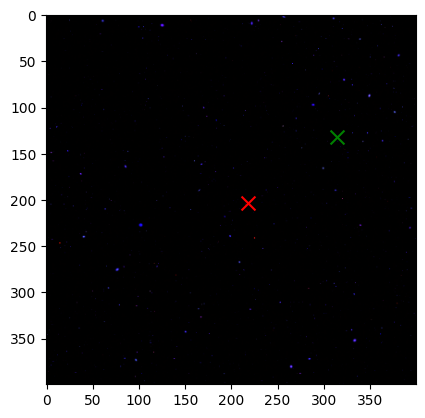

In [34]:
visual(input, output, nn_output.detach().numpy())

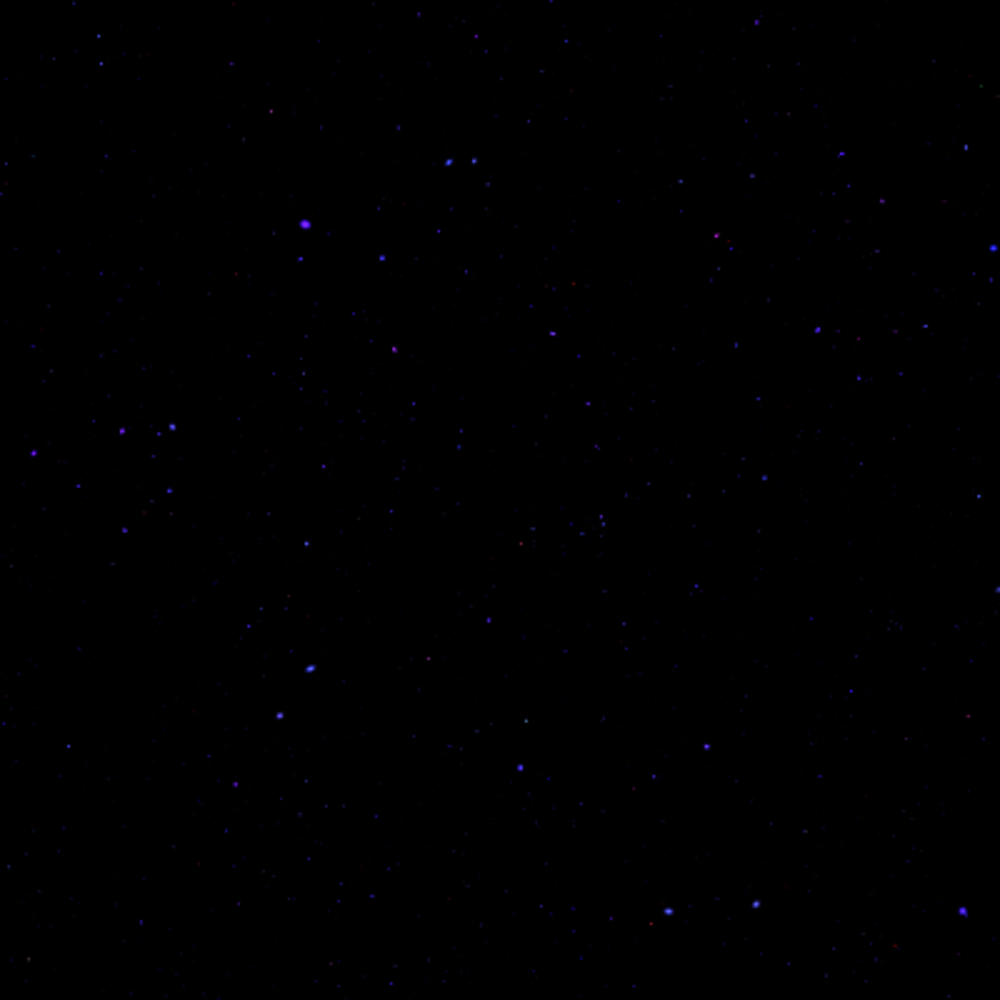

In [52]:
to_pil(input[0]).resize((1000, 1000))

In [18]:
from hmf import MassFunction
hmf = MassFunction()
hmf.update(Mmin=14.5, Mmax = 15.5) 
mass_func = hmf.dndlnm


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Example PMF data (shorter for demonstration)
pmf =mass_func

# Outcomes (for the purpose of this visualization, assuming sequential outcomes starting from 1)
outcomes = np.arange(1, len(pmf) + 1)

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(outcomes, pmf, color='skyblue')
plt.xlabel('Outcome')
plt.ylabel('Probability')
plt.title('Probability Mass Function (PMF)')
plt.xticks(outcomes)
plt.grid(axis='y', linestyle='--')

# Show plot
plt.show()